In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    
    
    


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



x = preprocess_data(x=x_org, pp="mm")  # only x is standardized




features = dd.features
features





Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 
pre-processing: mm
Preprocessed data shape: (225350, 13)


['Grade_3',
 'Grade_4',
 'Grade_6',
 'Age',
 'Sex_1',
 'Grade_2',
 'Grade_5',
 'FIX_Y',
 'Grade_1',
 'IQ',
 'FIX_X',
 'FIX_DURATION',
 'Sex_2']

In [10]:

# df_data_to_use.head()



In [11]:

# x_org.head()



In [12]:

# y_org.head()



In [13]:

data_name



'dd_fix_demo'

In [14]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



## Load new test data

In [15]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data_2_G.xlsx")
print(data_sets_xls.sheet_names)




['demography_test_2', 'fixations_test_2', 'ground_truth']


In [16]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'ground_truth',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
    "Reading speed": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (28, 7)
 


,SubjectID,Sex,Grade,Age,IQ,Group,Reading speed
0,nnr10,1,3,9,25,1,76
1,nnr11,1,3,9,31,3,64
2,nnr2,2,3,9,26,3,62
3,nnr21,2,3,9,29,1,78
4,nnr23,1,3,9,33,1,115


In [17]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test_2',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID", "Sentence_ID",]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()





fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ", "Group",
            ],
        )

fix_demo_new

Loading Fix data: 
  (17256, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Group
0,nnr10,4,1,148.1,513.9,293,1,3,9,25,1
1,nnr10,4,2,187.6,527.7,275,1,3,9,25,1
2,nnr10,4,1,158.6,526.2,188,1,3,9,25,1
3,nnr10,4,3,296.9,533.1,144,1,3,9,25,1
4,nnr10,4,3,276.5,534.4,184,1,3,9,25,1
...,...,...,...,...,...,...,...,...,...,...,...
742,nnr91,33,4,541.9,503.0,254,1,2,8,28,1
743,nnr91,33,4,520.2,498.2,191,1,2,8,28,1
744,nnr91,33,4,668.9,480.7,206,1,2,8,28,1
745,nnr91,33,6,969.0,492.4,226,1,2,8,28,1


In [ ]:



# # Artificially add rows with missing grades or gender to handle missing values during dummy conversion

# gender_diff = set(df_data_to_use.Sex).difference(set(fix_demo_new.Sex))

# grade_diff = set(df_data_to_use.Grade).difference(set(fix_demo_new.Grade))


# for d in grade_diff:
#     a_row = df_data_to_use.loc[df_data_to_use.Grade == d].iloc[0, :]
    
#     fix_demo_new.loc[-1] = a_row
#     fix_demo_new.index = fix_demo_new.index + 1  # shifting index

    


    
# for g in gender_diff:
#     a_row = df_data_to_use.loc[df_data_to_use.Sex == g].iloc[0, :]
    
#     fix_demo_new.loc[-1] = a_row
#     fix_demo_new.index = fix_demo_new.index + 1  # shifting index




# grade_diff



In [ ]:



# indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

# fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)





# fix_demo_new_dum



In [ ]:


# # Remove the the last two rows added synthetically to handle missing 5th and 6th grades.
# n_index = len(gender_diff) + len(grade_diff)

# # x_dum_test = fix_stats_demo_new_dum.drop(fix_stats_demo_new_dum.index[-n_index:])
# x_dum_test = fix_demo_new_dum.drop(fix_demo_new_dum.index[-n_index:])
    
# x_dum_test



In [18]:


_ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
demo_phono = dd.concat_classes_demo()

# The optimize way to exclude at-risk class
if to_exclude_at_risk == 1:
    to_exclude_at_risk = True
    demo_phono = demo_phono.loc[demo_phono.Group != 2]

demo_old = demo_phono.loc[:, [
    'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
]]

c_features = ['Sex', 'Grade', ]



Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [19]:



demo_old_norm = demo_old.loc[demo_old.Group == 1]
demo_old_risk = demo_old.loc[demo_old.Group == 2]
demo_old_dys  = demo_old.loc[demo_old.Group == 3]


demo_new_norm = demo_new.loc[demo_new.Group == 1]
demo_new_risk = demo_new.loc[demo_new.Group == 2]
demo_new_dys  = demo_new.loc[demo_new.Group == 3]




# Data sets comparison 



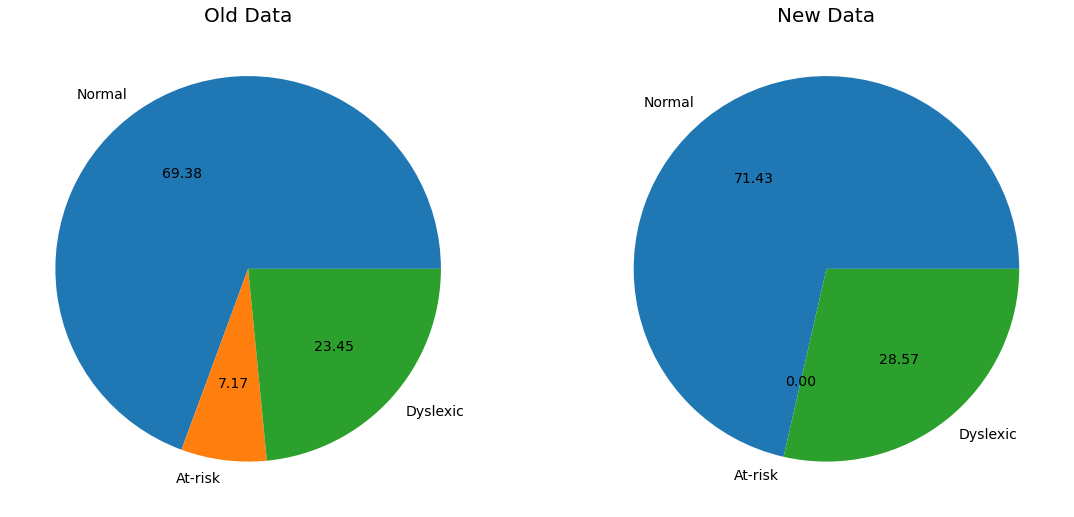

In [21]:


old_demo_stats = [213, 22, 72, ]
new_demo_stats = [demo_new_norm.shape[0], demo_new_risk.shape[0], demo_new_dys.shape[0], ]


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 2, 1)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=old_demo_stats, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Data', fontsize=20)


ax = fig.add_subplot(1, 2, 2)  # 2 datasets
patches, texts, autotexts = ax.pie(
    x=new_demo_stats, 
    labels=['Normal', 'At-risk', 'Dyslexic'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Data', fontsize=20)


plt.show()




In [22]:

genders = [1, 2]

genders_old      = [len(demo_old['Sex'].loc[demo_old['Sex']==f]) for f in genders]
genders_old_norm = [len(demo_old_norm['Sex'].loc[demo_old_norm['Sex']==f]) for f in [1, 2]]
genders_old_risk = [len(demo_old_risk['Sex'].loc[demo_old_risk['Sex']==f]) for f in [1, 2]]
genders_old_dys  = [len(demo_old_dys['Sex'].loc[demo_old_dys['Sex']==f]) for f in genders]


genders_new      = [len(demo_new['Sex'].loc[demo_new['Sex']==f]) for f in genders]
genders_new_norm = [len(demo_new_norm['Sex'].loc[demo_new_norm['Sex']==f]) for f in [1, 2]]
genders_new_risk = [len(demo_new_risk['Sex'].loc[demo_new_risk['Sex']==f]) for f in [1, 2]]
genders_new_dys  = [len(demo_new_dys['Sex'].loc[demo_new_dys['Sex']==f]) for f in genders]




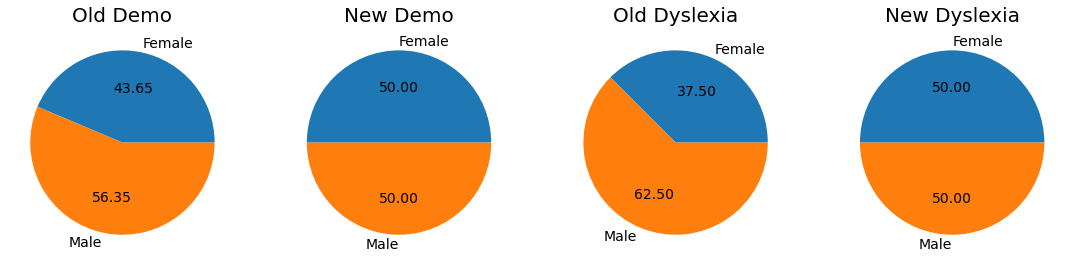

In [28]:


fig = plt.figure(figsize=(19, 13))



ax = fig.add_subplot(1, 4, 1)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=genders_old, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Demo', fontsize=20)


ax = fig.add_subplot(1, 4, 2)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=genders_new, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Demo', fontsize=20)



ax = fig.add_subplot(1, 4, 3)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=genders_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Dyslexia', fontsize=20)


ax = fig.add_subplot(1, 4, 4)  # 4 datasets
patches, texts, autotexts = ax.pie(
    x=genders_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexia', fontsize=20)

plt.show()



normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


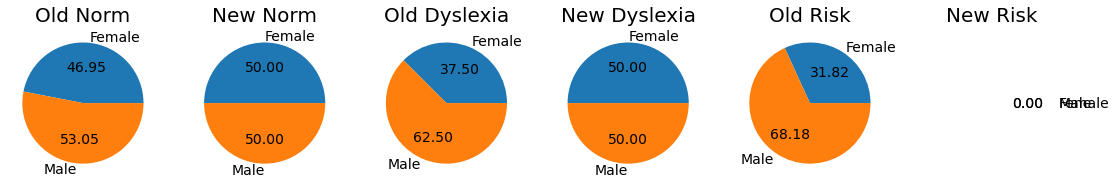

In [35]:


fig = plt.figure(figsize=(19, 13))


ax = fig.add_subplot(1, 6, 1)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_old_norm, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 2)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_new_norm, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}
)

plt.title('New Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 3)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_old_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Dyslexia', fontsize=20)


ax = fig.add_subplot(1, 6, 4)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_new_dys, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexia', fontsize=20)

ax = fig.add_subplot(1, 6, 5)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_old_risk, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Risk', fontsize=20)


ax = fig.add_subplot(1, 6, 6)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=genders_new_risk, 
    labels=['Female', 'Male'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Risk', fontsize=20)



plt.show()



In [36]:


grades = [1, 2, 3, 4, 5, 6]


grades_old      = [len(demo_old['Grade'].loc[demo_old['Grade']==f]) for f in grades]
grades_old_norm = [len(demo_old_norm['Grade'].loc[demo_old_norm['Grade']==f]) for f in grades]
grades_old_dys  = [len(demo_old_dys['Grade'].loc[demo_old_dys['Grade']==f]) for f in grades]




grades_new      = [len(demo_new['Grade'].loc[demo_new['Grade']==f]) for f in grades]
grades_new_norm = [len(demo_new_norm['Grade'].loc[demo_new_norm['Grade']==f]) for f in grades]
grades_new_dys  = [len(demo_new_dys['Grade'].loc[demo_new_dys['Grade']==f]) for f in grades]




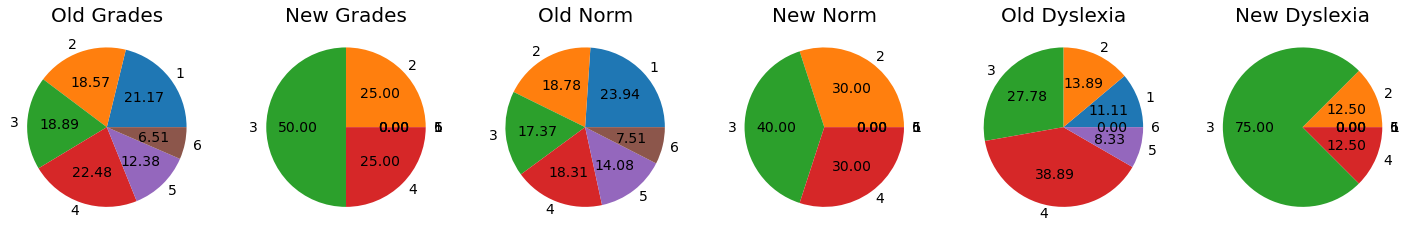

In [37]:





fig = plt.figure(figsize=(25, 15))


ax = fig.add_subplot(1, 6, 1)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Grades', fontsize=20)

ax = fig.add_subplot(1, 6, 2)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('New Grades', fontsize=20)


ax = fig.add_subplot(1, 6, 3)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old_norm, 
    labels=['1', '2', '3', '4', '5', '6'],
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)


plt.title('Old Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 4)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new_norm, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}
)

plt.title('New Norm', fontsize=20)


ax = fig.add_subplot(1, 6, 5)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_old_dys, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)
    
plt.title('Old Dyslexia', fontsize=20)


ax = fig.add_subplot(1, 6, 6)  # 6 datasets
patches, texts, autotexts = ax.pie(
    x=grades_new_dys, 
    labels=['1', '2', '3', '4', '5', '6'], 
    autopct='%.2f', 
    textprops={'fontsize': 14}                                   
)

plt.title('New Dyslexia', fontsize=20)



plt.show()






# Fixation data sets comparison



In [44]:


grade_3_old      = fix_demo.loc[fix_demo.Grade == 3]
grade_3_old_norm = grade_3_old.loc[grade_3_old.Group == 1]
grade_3_old_dys  = grade_3_old.loc[grade_3_old.Group == 3]



In [45]:

grade_3_new      = fix_demo_new.loc[fix_demo_new.Grade == 3]
grade_3_new_norm = grade_3_new.loc[grade_3_new.Group == 1]
grade_3_new_dys  = grade_3_new.loc[grade_3_new.Group == 3]



In [46]:

features_to_show = [
    "Sex", "Age", "IQ", "FIX_X", "FIX_Y", "FIX_DURATION",
]

features_to_show


['Sex', 'Age', 'IQ', 'FIX_X', 'FIX_Y', 'FIX_DURATION']

In [47]:


g3_o_n = grade_3_old_norm.loc[:, features_to_show].describe()

g3_o_n



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,23944.000000,23944.000000,23944.000000,23944.000000,23944.000000,23944.000000
mean,1.502840,9.265662,31.331231,618.611523,538.654987,221.306465
std,0.500002,0.441694,3.496515,298.598718,27.044846,140.807049
min,1.000000,9.000000,21.000000,120.200000,333.300000,1.000000
25%,1.000000,9.000000,30.000000,365.500000,522.400000,145.000000
50%,2.000000,9.000000,32.000000,594.700000,537.100000,196.000000
75%,2.000000,10.000000,34.000000,865.600000,553.600000,274.000000
max,2.000000,10.000000,35.000000,1419.400000,725.100000,4190.000000


In [48]:

g3_n_n = grade_3_new_norm.loc[:, features_to_show].describe()
g3_n_n



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000
mean,1.553809,8.886269,29.847413,614.506134,542.875267,251.711853
std,0.497150,0.317518,2.594011,298.487786,20.473253,137.637142
min,1.000000,8.000000,25.000000,122.200000,429.800000,7.000000
25%,1.000000,9.000000,29.000000,362.100000,528.100000,164.000000
50%,2.000000,9.000000,31.000000,591.300000,542.100000,218.000000
75%,2.000000,9.000000,32.000000,860.400000,557.600000,299.000000
max,2.000000,9.000000,33.000000,1424.500000,709.200000,1948.000000


## Difference between old and new 3rd grade normals



In [51]:

g3_o_n - g3_n_n



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,19363.000000,19363.000000,19363.000000,19363.000000,19363.000000,19363.000000
mean,-0.050969,0.379392,1.483818,4.105389,-4.220281,-30.405388
std,0.002852,0.124176,0.902504,0.110932,6.571593,3.169907
min,0.000000,1.000000,-4.000000,-2.000000,-96.500000,-6.000000
25%,0.000000,0.000000,1.000000,3.400000,-5.700000,-19.000000
50%,0.000000,0.000000,1.000000,3.400000,-5.000000,-22.000000
75%,0.000000,1.000000,2.000000,5.200000,-4.000000,-25.000000
max,0.000000,1.000000,2.000000,-5.100000,15.900000,2242.000000


In [52]:


g3_o_d = grade_3_old_dys.loc[:, features_to_show].describe()
g3_o_d



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,15947.000000,15947.000000,15947.000000,15947.000000,15947.000000,15947.000000
mean,1.374052,9.258481,32.014548,625.939412,533.768025,327.457516
std,0.483892,0.542820,5.171877,303.669384,21.410725,208.624760
min,1.000000,8.000000,15.000000,120.000000,480.000000,1.000000
25%,1.000000,9.000000,31.000000,365.200000,520.000000,193.000000
50%,1.000000,9.000000,34.000000,605.000000,535.100000,268.000000
75%,2.000000,10.000000,35.000000,873.650000,550.200000,399.500000
max,2.000000,10.000000,36.000000,1464.000000,574.900000,3344.000000


In [53]:


g3_n_d = grade_3_new_dys.loc[:, features_to_show].describe()

g3_n_d



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,4737.000000,4737.0,4737.000000,4737.000000,4737.000000,4737.000000
mean,1.506439,9.0,28.240025,613.754803,538.868778,296.841461
std,0.500011,0.0,2.731900,298.080138,22.851673,170.987196
min,1.000000,9.0,24.000000,120.000000,342.300000,2.000000
25%,1.000000,9.0,26.000000,357.300000,521.400000,181.000000
50%,2.000000,9.0,29.000000,588.500000,541.700000,245.000000
75%,2.000000,9.0,31.000000,864.200000,553.800000,372.000000
max,2.000000,9.0,32.000000,1410.300000,668.200000,1777.000000



## Difference between old and new 3rd grade dyslexia




In [55]:


g3_o_d - g3_n_d



,Sex,Age,IQ,FIX_X,FIX_Y,FIX_DURATION
count,11210.000000,11210.000000,11210.000000,11210.000000,11210.000000,11210.000000
mean,-0.132387,0.258481,3.774523,12.184609,-5.100752,30.616055
std,-0.016119,0.542820,2.439977,5.589246,-1.440947,37.637564
min,0.000000,-1.000000,-9.000000,0.000000,137.700000,-1.000000
25%,0.000000,0.000000,5.000000,7.900000,-1.400000,12.000000
50%,-1.000000,0.000000,5.000000,16.500000,-6.600000,23.000000
75%,0.000000,1.000000,4.000000,9.450000,-3.600000,27.500000
max,0.000000,1.000000,4.000000,53.700000,-93.300000,1567.000000


In [59]:


print(
    f"  FIX_X \t  ave \t   std        min \t  max \n"
    
    f" old nornmal : {g3_o_n.FIX_X[1]:.3f}   {g3_o_n.FIX_X[2]:.3f}   {g3_o_n.FIX_X[3]:.3f}   {g3_o_n.FIX_X[-1]:.3f} \n"
    f" new nornmal : {g3_n_n.FIX_X[1]:.3f}   {g3_n_n.FIX_X[2]:.3f}   {g3_n_n.FIX_X[3]:.3f}   {g3_n_n.FIX_X[-1]:.3f} \n"
    f" old dyslexia: {g3_o_d.FIX_X[1]:.3f}   {g3_o_d.FIX_X[2]:.3f}   {g3_o_d.FIX_X[3]:.3f}   {g3_o_d.FIX_X[-1]:.3f} \n"
    f" new dyslexia: {g3_n_d.FIX_X[1]:.3f}   {g3_n_d.FIX_X[2]:.3f}   {g3_n_d.FIX_X[3]:.3f}   {g3_n_d.FIX_X[-1]:.3f} \n"

)




  FIX_X 	  ave 	   std        min 	  max 
 old nornmal : 618.612   298.599   120.200   1419.400 
 new nornmal : 614.506   298.488   122.200   1424.500 
 old dyslexia: 625.939   303.669   120.000   1464.000 
 new dyslexia: 613.755   298.080   120.000   1410.300 




- Note the closness between ave. and stds of old_normal with new_normal and new_dyslexia
- Note the difference between min new_normal with the rest (calibration or raw data preprocessing issue)




In [61]:



print(
    f"  FIX_Y \t  ave \t   std        min \t  max \n"
    
    f" old nornmal : {g3_o_n.FIX_Y[1]:.3f}   {g3_o_n.FIX_Y[2]:.3f}   {g3_o_n.FIX_Y[3]:.3f}   {g3_o_n.FIX_Y[-1]:.3f} \n"
    f" new nornmal : {g3_n_n.FIX_Y[1]:.3f}   {g3_n_n.FIX_Y[2]:.3f}   {g3_n_n.FIX_Y[3]:.3f}   {g3_n_n.FIX_Y[-1]:.3f} \n"
    f" old dyslexia: {g3_o_d.FIX_Y[1]:.3f}   {g3_o_d.FIX_Y[2]:.3f}   {g3_o_d.FIX_Y[3]:.3f}   {g3_o_d.FIX_Y[-1]:.3f} \n"
    f" new dyslexia: {g3_n_d.FIX_Y[1]:.3f}   {g3_n_d.FIX_Y[2]:.3f}   {g3_n_d.FIX_Y[3]:.3f}   {g3_n_d.FIX_Y[-1]:.3f} \n"
)




  FIX_Y 	  ave 	   std        min 	  max 
 old nornmal : 538.655   27.045   333.300   725.100 
 new nornmal : 542.875   20.473   429.800   709.200 
 old dyslexia: 533.768   21.411   480.000   574.900 
 new dyslexia: 538.869   22.852   342.300   668.200 




- Note the almost identical ave. of old_normal and new_deslexia (with ~ similar stds)

- Note the larger value of new_normal ave than others

- Note the difference between min values of new_normal with old_normal

- Note the difference between min values of new_dyslexia with old_dyslexia (calibration or raw data preprocessing issue)



In [63]:


print(
    f"  FIX_DURATION \t  ave \t   std        min \t  max \n"
    
    f" old nornmal : {g3_o_n.FIX_DURATION[1]:.3f}   {g3_o_n.FIX_DURATION[2]:.3f}   {g3_o_n.FIX_DURATION[3]:.3f}   {g3_o_n.FIX_DURATION[-1]:.3f} \n"
    f" new nornmal : {g3_n_n.FIX_DURATION[1]:.3f}   {g3_n_n.FIX_DURATION[2]:.3f}   {g3_n_n.FIX_DURATION[3]:.3f}   {g3_n_n.FIX_DURATION[-1]:.3f} \n"
    f" old dyslexia: {g3_o_d.FIX_DURATION[1]:.3f}   {g3_o_d.FIX_DURATION[2]:.3f}   {g3_o_d.FIX_DURATION[3]:.3f}   {g3_o_d.FIX_DURATION[-1]:.3f} \n"
    f" new dyslexia: {g3_n_d.FIX_DURATION[1]:.3f}   {g3_n_d.FIX_DURATION[2]:.3f}   {g3_n_d.FIX_DURATION[3]:.3f}   {g3_n_d.FIX_DURATION[-1]:.3f} \n"
)



  FIX_DURATION 	  ave 	   std        min 	  max 
 old nornmal : 221.306   140.807   1.000   4190.000 
 new nornmal : 251.712   137.637   7.000   1948.000 
 old dyslexia: 327.458   208.625   1.000   3344.000 
 new dyslexia: 296.841   170.987   2.000   1777.000 




- Note the difference between the ave. of new_normal and old_normal: why people of the same grade and the same group should have such big difference? (IQ, and Age might be the reason, and this proves the necessecity of collecting larger data sets) 

    - g3_o_n.FIX_DURATION[1] - g3_n_n.FIX_DURATION[1] = -30.405388221939376
    
    

- Similarly, difference between the ave. of new_dyslexia and old_dyslexia:

    - g3_o_d.FIX_DURATION[1] - g3_n_d.FIX_DURATION[1] = 30.61605467996634


- Old data: g3_o_n.FIX_DURATION[1] - g3_o_d.FIX_DURATION[1] = -106.15105043496175 while
- New data: g3_n_n.FIX_DURATION[1] - g3_n_d.FIX_DURATION[1] = -45.12960753305603

Do you see the difference?


- Note the difference between min of new and old data fixation_duration



In [74]:

print(
    f"  IQ \t  ave \t   std        min \t  max \n"
    
    f" old nornmal : {g3_o_n.IQ[1]: .3f}   {g3_o_n.IQ[2]:.3f}   {g3_o_n.IQ[3]:.3f}   {g3_o_n.IQ[-1]:.3f} \n"
    f" new nornmal : {g3_n_n.IQ[1]: .3f}   {g3_n_n.IQ[2]:.3f}   {g3_n_n.IQ[3]:.3f}   {g3_n_n.IQ[-1]:.3f} \n"
    f" old dyslexia: {g3_o_d.IQ[1]: .3f}   {g3_o_d.IQ[2]:.3f}   {g3_o_d.IQ[3]:.3f}   {g3_o_d.IQ[-1]:.3f} \n"
    f" new dyslexia: {g3_n_d.IQ[1]: .3f}   {g3_n_d.IQ[2]:.3f}   {g3_n_d.IQ[3]:.3f}   {g3_n_d.IQ[-1]:.3f} \n"
)



  IQ 	  ave 	   std        min 	  max 
 old nornmal :  31.331   3.497   21.000   35.000 
 new nornmal :  29.847   2.594   25.000   33.000 
 old dyslexia:  32.015   5.172   15.000   36.000 
 new dyslexia:  28.240   2.732   24.000   32.000 



In [76]:
print(
    f"  Age \t  ave \t   std        min \t  max \n"
    
    f" old nornmal : {g3_o_n.Age[1]: .3f}   {g3_o_n.Age[2]:.3f}   {g3_o_n.Age[3]:.3f}   {g3_o_n.Age[-1]:.3f} \n"
    f" new nornmal : {g3_n_n.Age[1]: .3f}   {g3_n_n.Age[2]:.3f}   {g3_n_n.Age[3]:.3f}   {g3_n_n.Age[-1]:.3f} \n"
    f" old dyslexia: {g3_o_d.Age[1]: .3f}   {g3_o_d.Age[2]:.3f}   {g3_o_d.Age[3]:.3f}   {g3_o_d.Age[-1]:.3f} \n"
    f" new dyslexia: {g3_n_d.Age[1]: .3f}   {g3_n_d.Age[2]:.3f}   {g3_n_d.Age[3]:.3f}   {g3_n_d.Age[-1]:.3f} \n"
)




  Age 	  ave 	   std        min 	  max 
 old nornmal :  9.266   0.442   9.000   10.000 
 new nornmal :  8.886   0.318   8.000   9.000 
 old dyslexia:  9.258   0.543   8.000   10.000 
 new dyslexia:  9.000   0.000   9.000   9.000 






- New normals age is similar to grade 2 rather than grade 3; 

- More so, ave of old_normals for this grade was 9.3 ± 0.442 while ave of new_nornmals is nor  8.886  ± 0.318  

- These are indeed missing and new data, expecting any ML method with the current data set size to generize such unseen data points is indeed unrealistic



